In [1]:
import numpy as np
import matplotlib.pyplot as plt

I combined $f_1$ and $f_2$ equation for $b$. Note that
$$f_1-f_2=-(1-\beta\theta)\hat{mu}+\beta\theta\hat{\pi}+\beta\theta(f_{1,t+1}-f_{2,t+1})$$
Hence
$$\hat{b}_t=-(1-\beta\theta)\hat{mu}+\beta\theta\hat{\pi}+\beta\theta\hat{b}_{t+1}$$

In [2]:
from sequence_jacobian import simple, create_model

@simple
def HH(c, n, varphi, gamma):
    wp = varphi * n + gamma * c
    return wp

@simple
def Firm(wp, n, pi, a, theta):
    y = a + n
    mu = a - wp
    b = theta*pi / (1-theta)
    return y, mu, b

@simple
def central_bank(pi, phi_pi):
    i = phi_pi * pi
    return i

@simple
def mkt_clearing(y, mu, c, i, pi, b, theta, gamma):
    euler = gamma * c + i - pi(+1) - gamma * c(+1)
    mkt_c = c - y
    b_clr = -(1-beta*theta)*mu+beta*theta*pi+beta*theta*b(+1)-b
    r = i - pi(+1)
    return euler, mkt_c, b_clr, r

In [3]:
nk = create_model([HH, Firm, central_bank, mkt_clearing], name="NK")

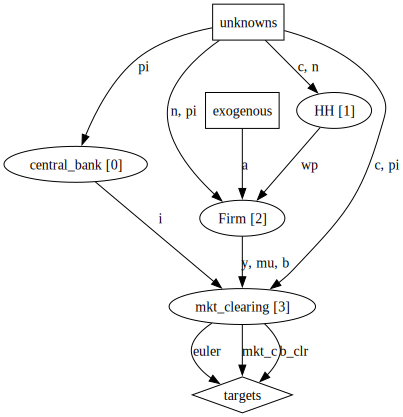

In [4]:
from sequence_jacobian.utilities.drawdag import drawdag

unknowns = ['c', 'n', 'pi']
targets = ['euler', 'mkt_c', 'b_clr']
inputs = ['a']

drawdag(nk, inputs, unknowns, targets, save="nk.png")

In [5]:
# initial parameters
gamma = 1
varphi = 1
chi = 1
varepsilon = 10
phi_y = 0
beta = 0.99
phi_pi = 1.5
theta = 0.01
rho_a = 0.8

# steady state values
calibration = {'a': 0, 'y': 0, 'r': 0, 'i': 0, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'varphi': varphi, 'theta': theta}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'c': 0, 'n': 0, 'pi': 0}
targets_ss = {"euler": 0, 'mkt_c': 0, 'b_clr': 0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# checking that we are in the steady state that we expect
assert np.allclose(ss['pi'], 0)
assert np.allclose(ss['euler'], 0)

In [6]:
G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

<JacobianDict outputs=['c', 'n', 'pi', 'wp', 'y', 'mu', 'b', 'i', 'euler', 'mkt_c', 'b_clr', 'r'], inputs=['a']>


In [7]:
T, Tplot, impact, news = 300, 20, 0.01, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho_a **np.arange(T)

In [8]:
y = (G['y']['a']@da)[:Tplot]
yflex = (1+varphi)/(varphi+gamma)*da[:Tplot]
n = (G['n']['a']@da)[:Tplot]
i = (G['i']['a']@da)[:Tplot]
r = (G['r']['a']@da)[:Tplot]
mu = (G['mu']['a']@da)[:Tplot]
pi = (G['pi']['a']@da)[:Tplot]
c = (G['c']['a']@da)[:Tplot]

Text(0.5, 1.0, 'Nominal Interest Rate')

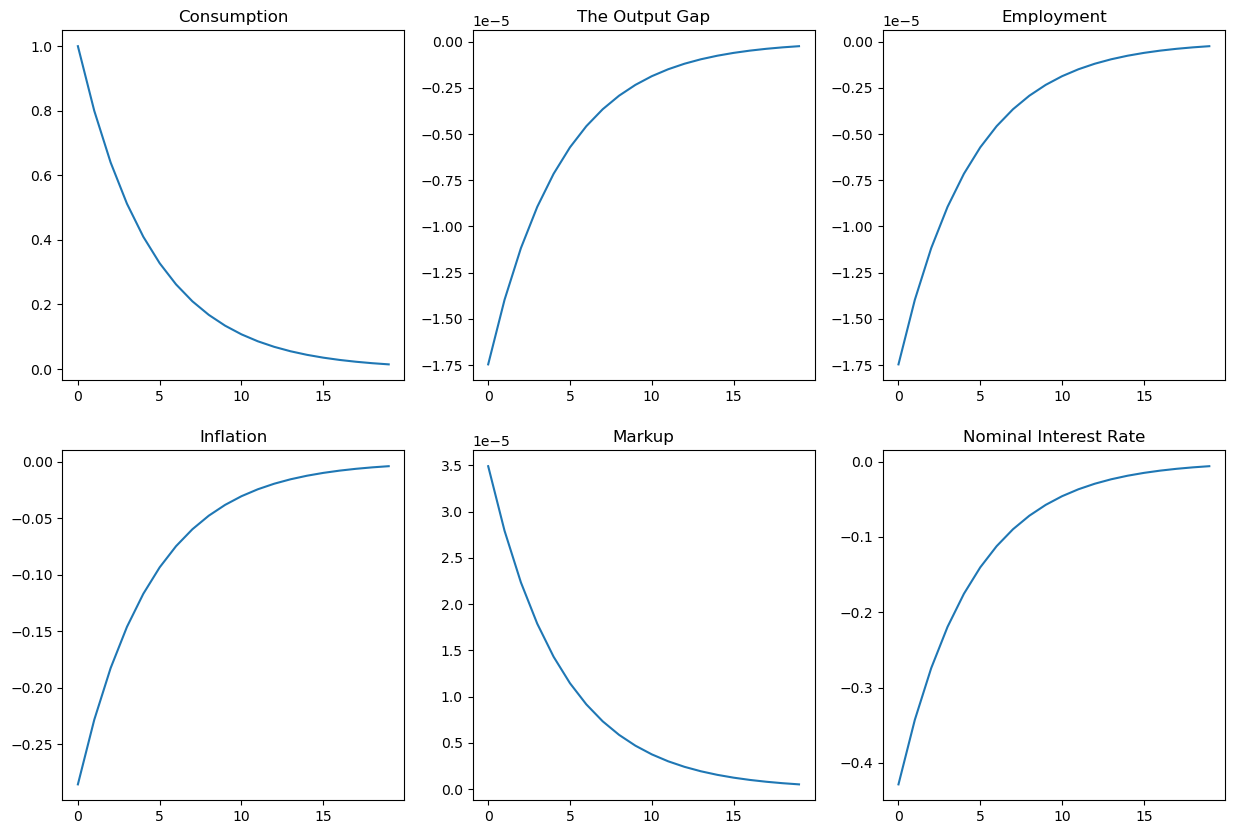

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].plot(100*c)
ax[0, 0].set_title('Consumption')

ax[0, 1].plot(100*(y-yflex))
ax[0, 1].set_title('The Output Gap')

ax[0, 2].plot(100*n)
ax[0, 2].set_title('Employment')

ax[1, 0].plot(100*pi)
ax[1, 0].set_title('Inflation')

ax[1, 1].plot(100*mu)
ax[1, 1].set_title('Markup')

ax[1, 2].plot(100*i)
ax[1, 2].set_title('Nominal Interest Rate')

## Different theta

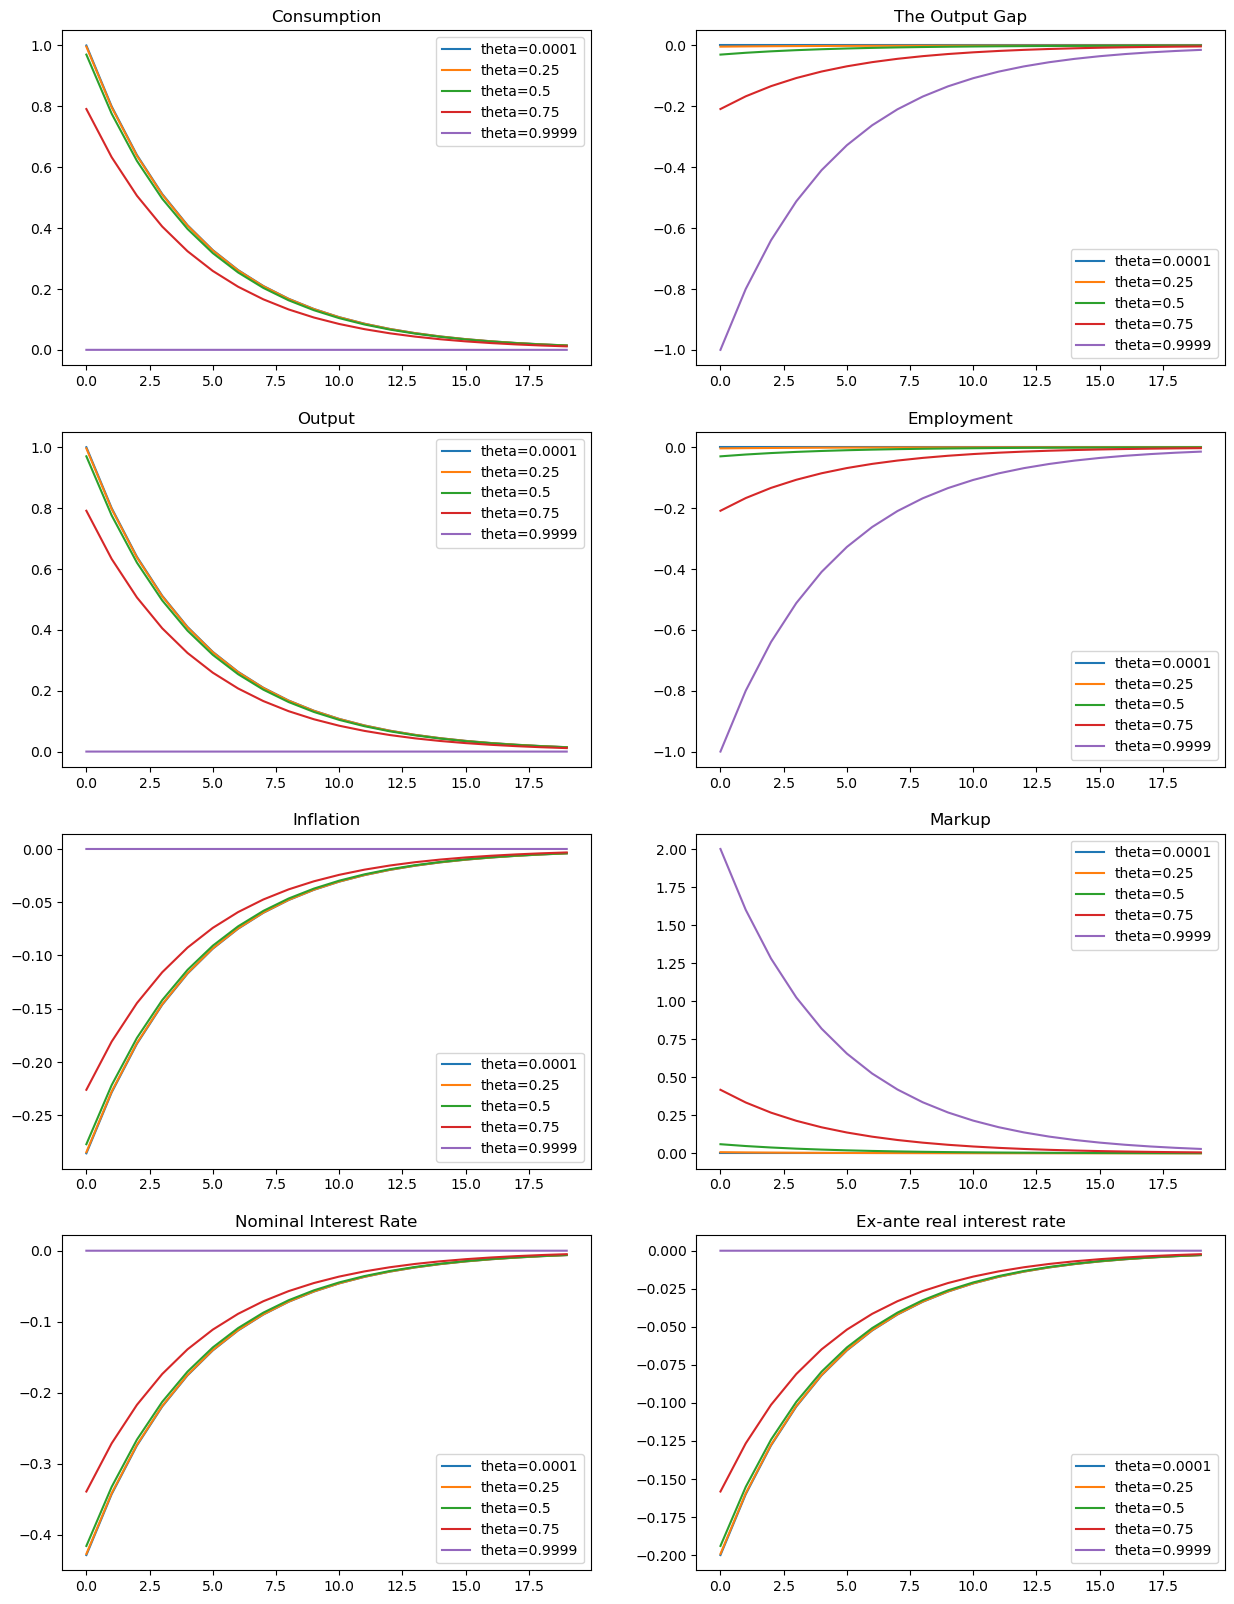

In [17]:
theta_array = [0.0001, 0.25, 0.5, 0.75, 0.9999]
T, Tplot, impact, news = 300, 20, 0.01, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho_a **np.arange(T)

fig, ax = plt.subplots(4, 2, figsize=(15, 20))
for theta in theta_array:
    calibration = {'a': 0, 'y': 0, 'r': 0, 'i': 0, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'varphi': varphi, 'theta': theta}
    ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")
    G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)
    y = (G['y']['a']@da)[:Tplot]
    yflex = (1+varphi)/(varphi+gamma)*da[:Tplot]
    n = (G['n']['a']@da)[:Tplot]
    i = (G['i']['a']@da)[:Tplot]
    r = (G['r']['a']@da)[:Tplot]
    mu = (G['mu']['a']@da)[:Tplot]
    pi = (G['pi']['a']@da)[:Tplot]
    c = (G['c']['a']@da)[:Tplot]
    ax[0, 0].plot(100*c, label=f'theta={theta}')
    ax[0, 0].set_title('Consumption')
    ax[0, 0].legend()

    ax[0, 1].plot(100*(y-yflex), label=f'theta={theta}')
    ax[0, 1].set_title('The Output Gap')
    ax[0, 1].legend()

    ax[1, 0].plot(100*y, label=f'theta={theta}')
    ax[1, 0].set_title('Output')
    ax[1, 0].legend()

    ax[1, 1].plot(100*n, label=f'theta={theta}')
    ax[1, 1].set_title('Employment')
    ax[1, 1].legend()

    ax[2, 0].plot(100*pi, label=f'theta={theta}')
    ax[2, 0].set_title('Inflation')
    ax[2, 0].legend()

    ax[2, 1].plot(100*mu, label=f'theta={theta}')
    ax[2, 1].set_title('Markup')
    ax[2, 1].legend()

    ax[3, 0].plot(100*i, label=f'theta={theta}')
    ax[3, 0].set_title('Nominal Interest Rate')
    ax[3, 0].legend()

    ax[3, 1].plot(100*r, label=f'theta={theta}')
    ax[3, 1].set_title('Ex-ante real interest rate')
    ax[3, 1].legend()
plt.savefig('q2_plot.png', dpi=300)